In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm
import torch
from torch import nn
from torchvision.models import (
    resnet18, ResNet18_Weights,
    resnet34, ResNet34_Weights,
    resnet50, ResNet50_Weights,
    resnet101, ResNet101_Weights,
    vit_b_16, ViT_B_16_Weights,
    vit_b_32, ViT_B_32_Weights,
    vgg16, VGG16_Weights, 
    vgg16_bn, VGG16_BN_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights,
    convnext_base, ConvNeXt_Base_Weights,
    efficientnet_v2_s, EfficientNet_V2_S_Weights,
    efficientnet_v2_m, EfficientNet_V2_M_Weights
)
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, Resize, Lambda, ToTensor, Grayscale, ToPILImage
import timm
from timm.data import resolve_data_config, create_transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import PIL

import sys
sys.path.append('./benchmarking-uncertainty-estimation-performance-main/utils')
from temperature_scaling import ModelWithTemperature
from uncertainty_metrics import AUROC, ECE_calc
from general_calibration_error import gce

torch.manual_seed(0)
np.random.seed(0)
rng = np.random.default_rng(0)

path_results = os.path.dirname(os.getcwd()) + '/results'
path_dataset = os.path.expandvars('$DSDIR/imagenet') # '/scratchf/'
path_imagenet_labels = os.path.expandvars('$WORK/DATA/LOC_synset_mapping.txt')
path_imagenet100_id = os.path.expandvars('$WORK/DATA/imagenet100.txt')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)



cuda


/tmp/ipykernel_921126/2992921061.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
BATCH_SIZE = 64
MODEL = 'ViT_B_16' 

# TORCHVISION
models_and_weights_torchvision = {
    'ResNet18': (resnet18, ResNet18_Weights.IMAGENET1K_V1), # same/worse
    'ResNet34': (resnet34, ResNet34_Weights.IMAGENET1K_V1), # same/worse
    'ResNet50': (resnet50, ResNet50_Weights.IMAGENET1K_V1), # same/worse
    'ResNet50_V2': (resnet50, ResNet50_Weights.IMAGENET1K_V2), # better
    'ResNet101': (resnet101, ResNet101_Weights.IMAGENET1K_V1), # same/worse
    'ResNet101_V2': (resnet101, ResNet101_Weights.IMAGENET1K_V2), # better
    'ViT_B_16': (vit_b_16, ViT_B_16_Weights.IMAGENET1K_V1), # better
    'ViT_B_16_SWAG_E2E': (vit_b_16, ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1), # same/worse
    'ViT_B_16_SWAG_LINEAR': (vit_b_16, ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1), # same/worse
    'ViT_B_32': (vit_b_32, ViT_B_32_Weights.IMAGENET1K_V1), # better
    'VGG16': (vgg16, VGG16_Weights.IMAGENET1K_V1), # same/worse
    'VGG16_BN': (vgg16_bn, VGG16_BN_Weights.IMAGENET1K_V1), # same/worse
    'ConvNeXt_Tiny': (convnext_tiny, ConvNeXt_Tiny_Weights.IMAGENET1K_V1), # better
    'ConvNeXt_Base': (convnext_base, ConvNeXt_Base_Weights.IMAGENET1K_V1), # better
    'EfficientNet_V2_S': (efficientnet_v2_s, EfficientNet_V2_S_Weights.IMAGENET1K_V1), # better
    'EfficientNet_V2_M': (efficientnet_v2_m, EfficientNet_V2_M_Weights.IMAGENET1K_V1) # better
}

# TIMM
models_timm = [
    'vit_base_patch16_224', # same/worse
    'vit_base_patch16_224_in21k', # NEED TO CONVERT IN21K PREDICTIONS TO IN1K
    'vit_base_patch16_224_miil', # same/worse
    'vit_base_patch16_224_miil_in21k', # NEED TO CONVERT IN21K PREDICTIONS TO IN1K
    'vit_base_patch16_384', # same/worse
    'vit_base_patch32_224', # same/worse
    'vit_base_patch32_224_in21k', # NEED TO CONVERT IN21K PREDICTIONS TO IN1K
    'vit_base_patch32_384', # same/worse
    ]

if MODEL in models_and_weights_torchvision.keys():
    TORCHVISION_OR_TIMM = 'torchvision'
elif MODEL in models_timm:
    TORCHVISION_OR_TIMM = 'timm'
else:
    raise ValueError

In [3]:
# LOAD CLASSIFIER
if TORCHVISION_OR_TIMM == 'timm':
    classifier = timm.create_model(MODEL, pretrained=True).eval().to(device)
    transforms = timm.data.create_transform(**timm.data.resolve_data_config({}, model=classifier))

elif TORCHVISION_OR_TIMM == 'torchvision':
    model, weights = models_and_weights_torchvision[MODEL]
    classifier = model(weights=weights).eval().to(device)
    transforms = weights.transforms()


# LOAD DATA
dataset_train = ImageFolder(path_dataset+'/train', transform=transforms)
dataset_val = ImageFolder(path_dataset+'/val', transform=transforms)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False) # SHUFFLE FALSE IMPORTANT!
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False) # SHUFFLE FALSE IMPORTANT!
id_to_idx = {}
idx_to_label = {}
with open(path_imagenet_labels) as f:
    for i, line in enumerate(f):
        id_to_idx[line[:9]] = i
        idx_to_label[i] = line[10:-1]

# LOAD CLASSIF OUTPUTS
df_train = pd.read_csv(path_results + f'/classif_outputs/{TORCHVISION_OR_TIMM}/classif_outputs_{MODEL}_train.csv', index_col=0)
df_val = pd.read_csv(path_results + f'/classif_outputs/{TORCHVISION_OR_TIMM}/classif_outputs_{MODEL}_val.csv', index_col=0)

## Test temperature scaling effect

In [4]:
df = df_val

all_logits = torch.zeros((len(dataset_val), 1000))
all_labels = torch.zeros(len(dataset_val), dtype=int)
i = 0
for x, y in dataloader_val:
    with torch.no_grad():
        logits = classifier(x.to(device))
    all_logits[i:i+logits.shape[0], :] = logits.cpu()
    all_labels[i:i+logits.shape[0]] = y.cpu()
    i += logits.shape[0]

Text(0, 0.5, 'accuracy')

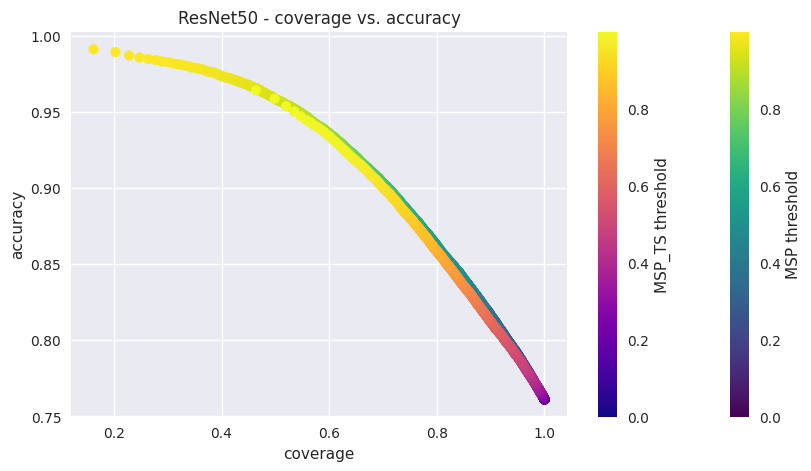

In [5]:
temperature = 0.5

# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df['MSP'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df.loc[idx_domain, 'well_classified'].mean()

# temperature scaling
msp_TS = torch.softmax(all_logits/temperature, axis=1).max(axis=1).values
domain_cutoff = np.linspace(0, 1, 1000)
coverage = np.zeros_like(domain_cutoff)
risk_ = np.zeros_like(domain_cutoff)
acc = np.zeros_like(domain_cutoff)
for i, cut in enumerate(domain_cutoff):
    idx_domain = (msp_TS > cut).numpy()
    coverage[i] = idx_domain.mean()
    acc[i] = df.loc[idx_domain, 'well_classified'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'{MODEL} - coverage vs. accuracy')
sc1 = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis')
sc2 = ax1.scatter(coverage, acc, c=domain_cutoff, cmap='plasma')
fig.colorbar(sc1, ax=ax1, label='MSP threshold')
fig.colorbar(sc2, ax=ax1, label='MSP_TS threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')

## T>1 uniformise les confiances, T<1 renforce les extremes

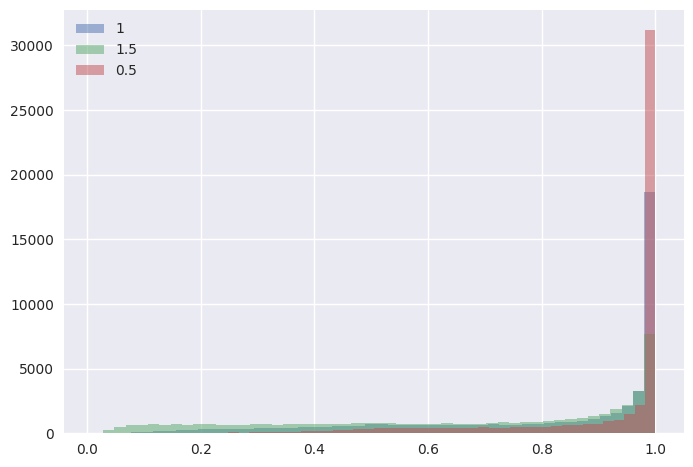

In [12]:
temperature_0 = 1
msp_TS_0 = torch.softmax(all_logits/temperature_0, axis=1).max(axis=1).values

temperature_1 = 1.5
msp_TS_1 = torch.softmax(all_logits/temperature_1, axis=1).max(axis=1).values

temperature_2 = 0.5
msp_TS_2 = torch.softmax(all_logits/temperature_2, axis=1).max(axis=1).values

plt.figure()
plt.hist(msp_TS_0, label=str(temperature_0), bins=50, alpha=0.5)
plt.hist(msp_TS_1, label=str(temperature_1), bins=50, alpha=0.5)
plt.hist(msp_TS_2, label=str(temperature_2), bins=50, alpha=0.5)
plt.legend()


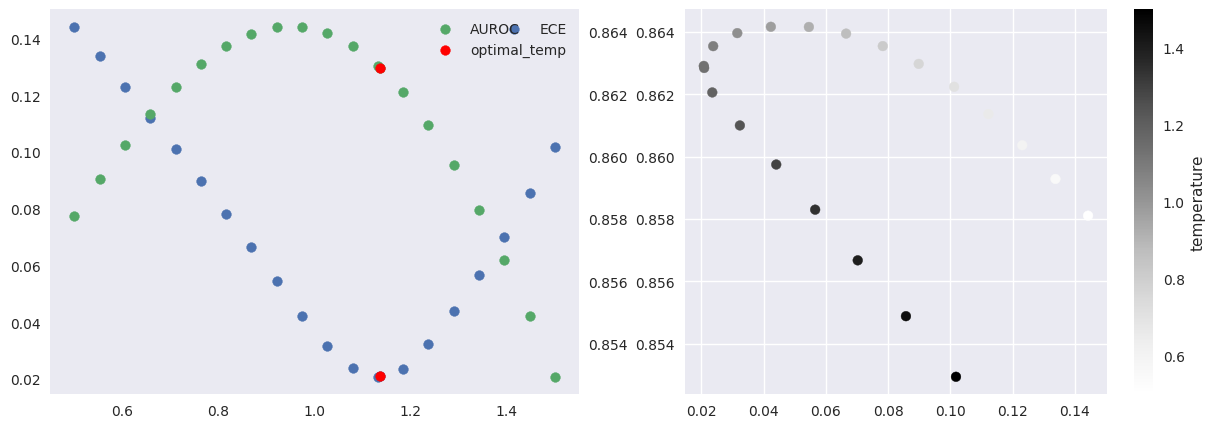

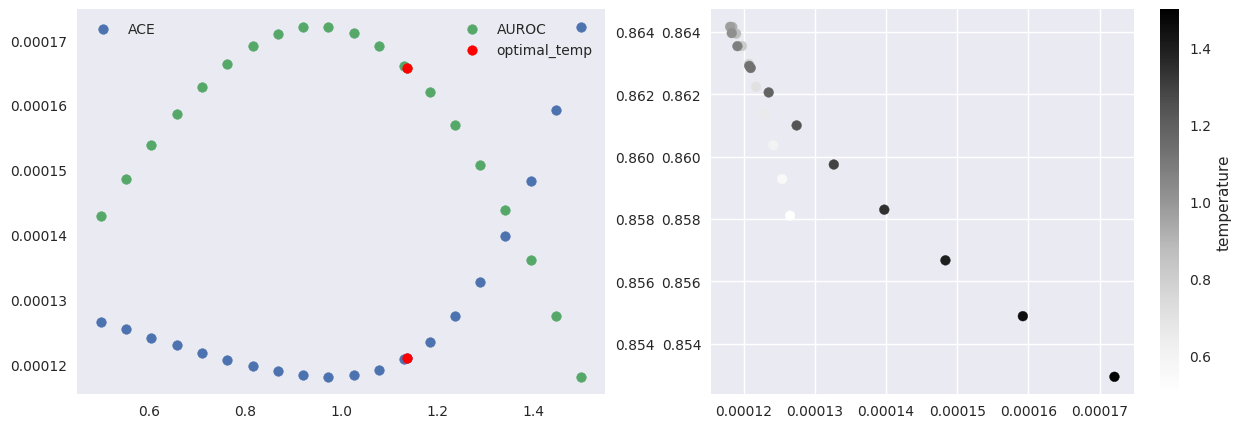

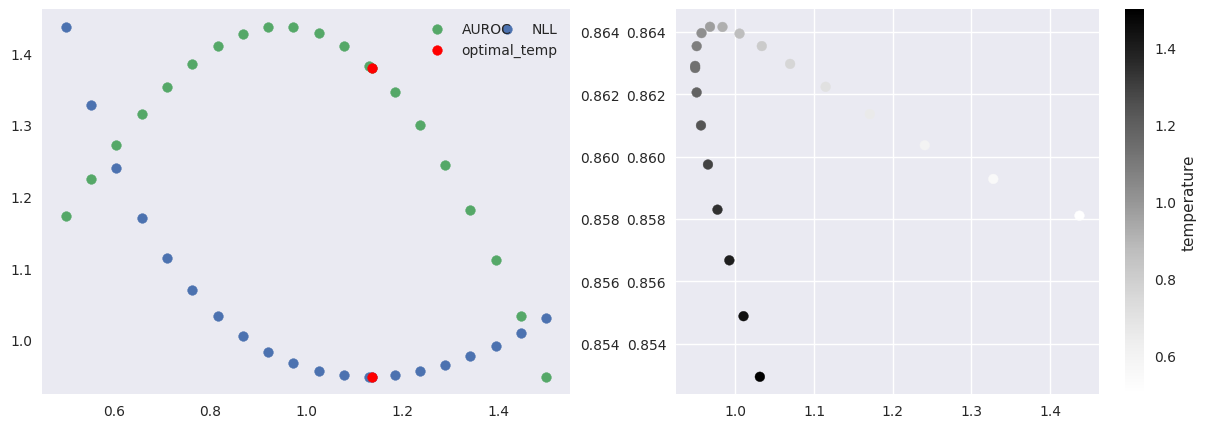

In [24]:
classifier_TS = ModelWithTemperature(classifier)
classifier_TS.set_temperature(dataloader_val)
optimal_temp = classifier_TS.temperature.item()

temperatures = np.append(optimal_temp, np.linspace(0.5, 1.5, 20))
ace = np.zeros_like(temperatures)
ece = np.zeros_like(temperatures)
auroc = np.zeros_like(temperatures)
nll = np.zeros_like(temperatures)

for i, t in enumerate(temperatures):
    probs = torch.softmax(all_logits/t, axis=1)
    certainties, y_pred = probs.max(axis=1)
    correct = y_pred == all_labels
    samples_certainties = torch.stack((certainties.cpu(), correct.cpu()), dim=1)
    log_probas = nn.functional.log_softmax(all_logits/t, dim=1)


    ece[i], _ = ECE_calc(samples_certainties)
    ace[i] = gce(all_labels, probs, binning_scheme='adaptive', class_conditional=True, max_prob=False, norm='l1')
    auroc[i] = AUROC(samples_certainties)
    nll[i] = nn.functional.nll_loss(log_probas, all_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(temperatures, ece, c='C0', label='ECE')
ax1.scatter(temperatures[0], ece[0], c='r')
ax1_1 = ax1.twinx()
ax1_1.scatter(temperatures, auroc, c='C1', label='AUROC')
ax1_1.scatter(temperatures[0], auroc[0], c='r', label='optimal_temp')
sc = ax2.scatter(ece, auroc, c=temperatures)
fig.colorbar(sc, ax=ax2, label='temperature')
ax1.legend()
ax1.grid(False)
ax1_1.legend()
ax1_1.grid(False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(temperatures, ace, c='C0', label='ACE')
ax1.scatter(temperatures[0], ace[0], c='r')
ax1_1 = ax1.twinx()
ax1_1.scatter(temperatures, auroc, c='C1', label='AUROC')
ax1_1.scatter(temperatures[0], auroc[0], c='r', label='optimal_temp')
sc = ax2.scatter(ace, auroc, c=temperatures)
fig.colorbar(sc, ax=ax2, label='temperature')
ax1.legend()
ax1.grid(False)
ax1_1.legend()
ax1_1.grid(False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(temperatures, nll, c='C0', label='NLL')
ax1.scatter(temperatures[0], nll[0], c='r')
ax1_1 = ax1.twinx()
ax1_1.scatter(temperatures, auroc, c='C1', label='AUROC')
ax1_1.scatter(temperatures[0], auroc[0], c='r', label='optimal_temp')
sc = ax2.scatter(nll, auroc, c=temperatures)
fig.colorbar(sc, ax=ax2, label='temperature')
ax1.legend()
ax1.grid(False)
ax1_1.legend()
ax1_1.grid(False)

## Temperature scaling vs multiply by accuracy/avg_confid

In [28]:
# all_logits = torch.zeros((len(dataset_val), 1000))
# all_labels = torch.zeros(len(dataset_val), dtype=int)
# i = 0
# for x, y in dataloader_val:
#     with torch.no_grad():
#         logits = classifier(x.to(device))
#     all_logits[i:i+logits.shape[0], :] = logits.cpu()
#     all_labels[i:i+logits.shape[0]] = y.cpu()
#     i += logits.shape[0]

t = 1
probs = torch.softmax(all_logits/t, axis=1)
certainties, y_pred = probs.max(axis=1)
correct = y_pred == all_labels
samples_certainties = torch.stack((certainties.cpu(), correct.cpu()), dim=1)

ece, _ = ECE_calc(samples_certainties)
auroc = AUROC(samples_certainties)
print('baseline')
print(ece)
print(auroc)

baseline
tensor(0.0560)
0.8561393673562108


In [60]:
t = 1
probs = torch.softmax(all_logits/t, axis=1)
certainties, y_pred = probs.max(axis=1)
correct = y_pred == all_labels
# scale by accuracy
coeff = correct.float().mean() / certainties.mean()
certainties = torch.clamp(certainties * coeff, 0, 1)
samples_certainties = torch.stack((certainties.cpu(), correct.cpu()), dim=1)

ece, _ = ECE_calc(samples_certainties)
auroc = AUROC(samples_certainties)
print('scale confidence')
print(ece)
print(auroc)

scale confidence
tensor(0.0141)
0.8561155671927664


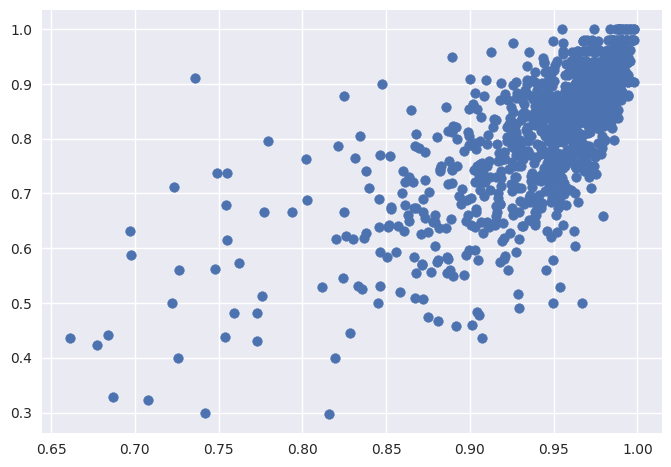

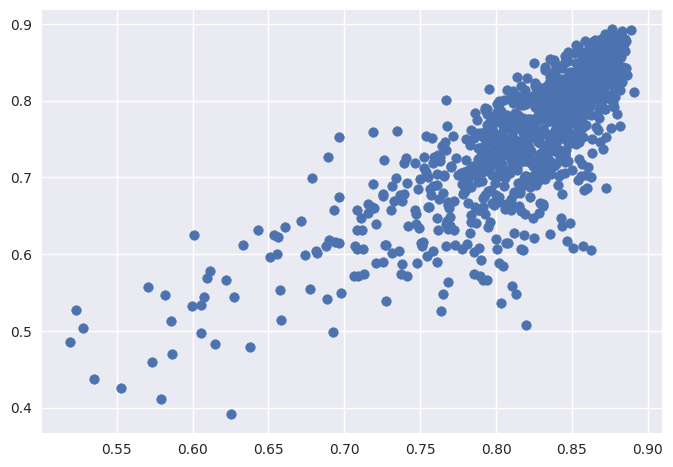

In [47]:
acc_per_class_train = [df_train.loc[df_train['pred']==c, 'well_classified'].mean() for c in range(1000)]
acc_per_class_val = [df_val.loc[df_val['pred']==c, 'well_classified'].mean() for c in range(1000)]

plt.figure()
plt.scatter(acc_per_class_train, acc_per_class_val)

avg_confid_per_class_train = [df_train.loc[df_train['pred']==c, 'MSP'].mean() for c in range(1000)]
avg_confid_per_class_val = [df_val.loc[df_val['pred']==c, 'MSP'].mean() for c in range(1000)]

plt.figure()
plt.scatter(avg_confid_per_class_train, avg_confid_per_class_val)


In [74]:
t = 1
probs = torch.softmax(all_logits/t, axis=1)
certainties, y_pred = probs.max(axis=1)
correct = y_pred == all_labels
# scale by accuracy
coeff = torch.tensor([acc_per_class_val[y.item()]/avg_confid_per_class_val[y.item()] for y in y_pred])
certainties = torch.clamp(certainties * coeff, 0, 1)
samples_certainties = torch.stack((certainties.cpu(), correct.cpu()), dim=1)

ece, _ = ECE_calc(samples_certainties)
auroc = AUROC(samples_certainties)
print('scale confidence per class')
print(ece)
print(auroc)

scale confidence per class
tensor(0.0122, dtype=torch.float64)
0.8734920555773744


In [31]:
# classifier_TS = ModelWithTemperature(classifier)
# classifier_TS.set_temperature(dataloader_val)
# optimal_temp = classifier_TS.temperature.item()

t = optimal_temp
probs = torch.softmax(all_logits/t, axis=1)
certainties, y_pred = probs.max(axis=1)
correct = y_pred == all_labels
samples_certainties = torch.stack((certainties.cpu(), correct.cpu()), dim=1)

ece, _ = ECE_calc(samples_certainties)
auroc = AUROC(samples_certainties)
print(ece)
print(auroc)

tensor(0.0364)
0.8637957850692412
